In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import ema, anet
from evolutions import *
from utils import stack_imgs
from evaluation import *
import PIL

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## MNIST

In [68]:
from utils import get_dataset_MNIST as get_dataset
from config_mnist import get_configs
config = get_configs()
config.data.norm_mean = (0.5)
config.data.norm_std = (0.5)
config.model.task = 'diffusion'
config.model.evolution = 'dimple'
C = config.data.num_channels

device = torch.device('cuda')
train_loader, val_loader = get_dataset(config)
q_t, sigma, w, dwdt = get_q(config)

In [64]:
x,y = next(iter(train_loader))
x, y = x[:64], y[:64]
x = x.view(64, -1)
y = torch.nn.functional.one_hot(y, num_classes=config.data.ydim).float()
x = torch.hstack([x, y])

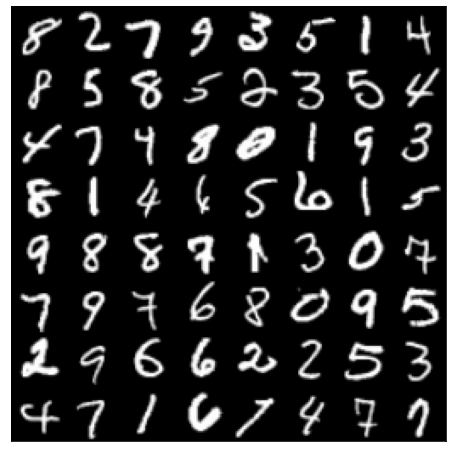

In [65]:
figsize(10,8)
big_img = stack_imgs(x[:,:-config.data.ydim].reshape([-1,C,32,32])*0.5+0.5)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

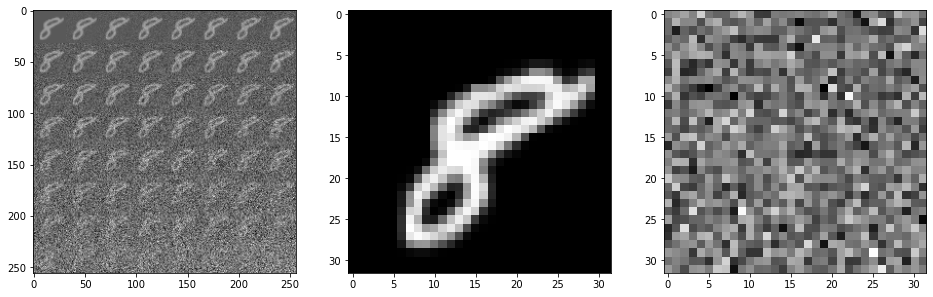

In [70]:
figsize(16,8)

batch = x[:1].repeat([64,1])
x_t = q_t(batch, torch.linspace(0,1,64))

img = np.zeros([8*32,8*32])
k = 0
for k in range(64):
    i, j = k//8, k % 8
    img[i*32:(i+1)*32,j*32:(j+1)*32] = x_t[k].reshape([32,32])*0.5+0.5
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(img[0:32,0:32], cmap='gray')
plt.subplot(133)
plt.imshow(img[i*32:(i+1)*32,j*32:(j+1)*32], cmap='gray')

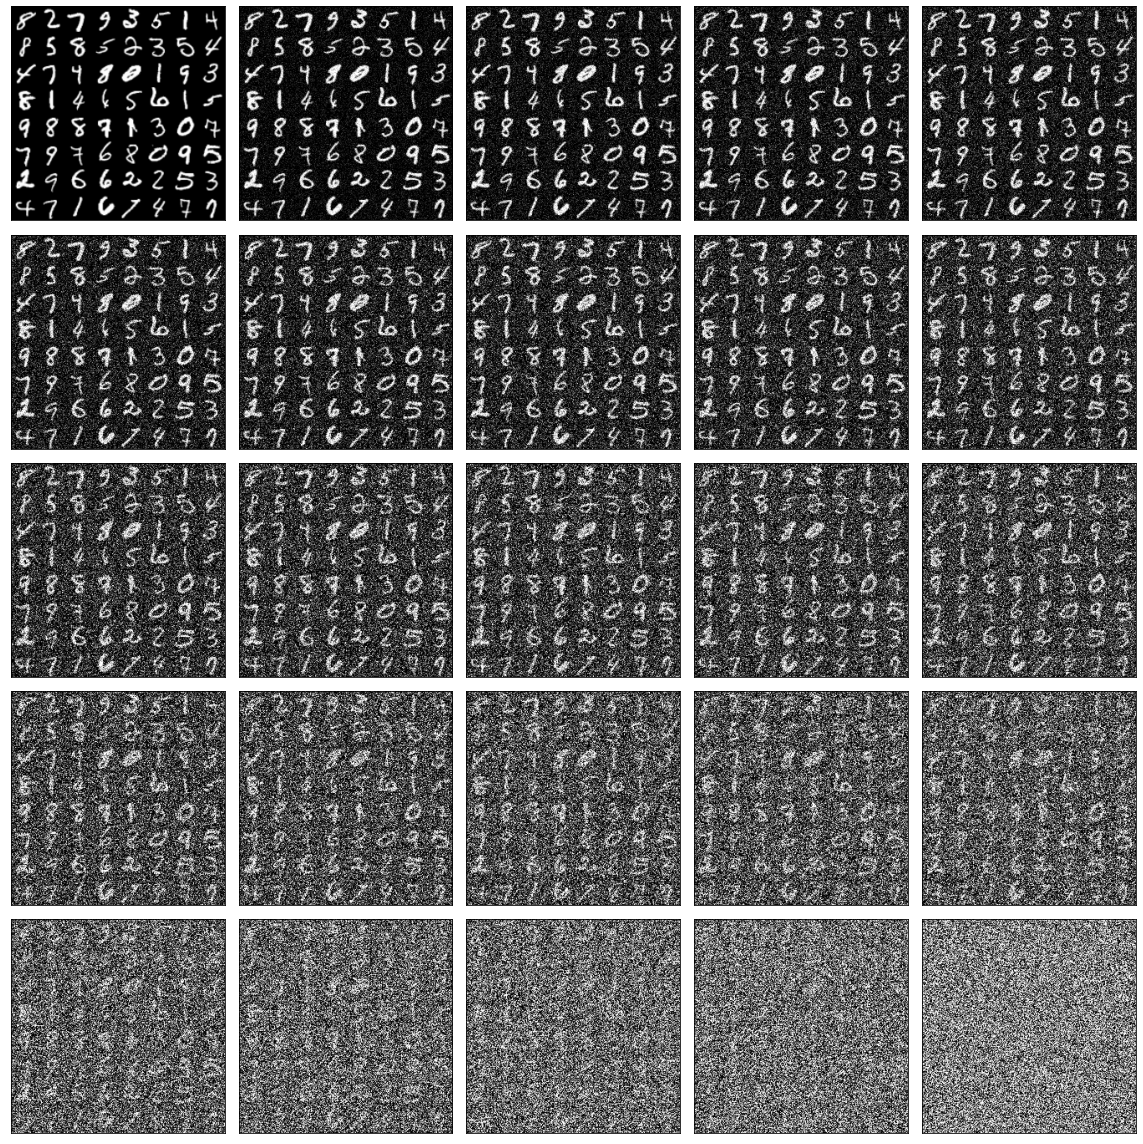

In [69]:
figsize(16,16)

batch = x[:1].repeat([64,1,1,1])
batch = batch.view(64, -1)
y = torch.zeros([64,config.data.ydim])
batch = torch.hstack([batch, y])
x_t = q_t(x, torch.linspace(0,1,64))

t = np.linspace(0,1,25)
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        img = q_t(x, torch.ones(64)*t[5*i+j])
        img = img.reshape([-1,C,32,32])*0.5+0.5
        plt.xticks([])
        plt.yticks([])
        plt.imshow(stack_imgs(img), cmap='gray')
plt.tight_layout()

## CIFAR

In [3]:
from utils import get_dataset_CIFAR10 as get_dataset
from config_cifar10_32 import get_configs
config = get_configs()
config.data.norm_mean = (0.5, 0.5, 0.5)
config.data.norm_std = (0.5, 0.5, 0.5)
config.model.task = 'color'
config.model.cond_channels = 0
config.model.evolution = 'dimple'
C = config.data.num_channels

device = torch.device('cuda')
train_loader, val_loader = get_dataset(config)
q_t, sigma, w, dwdt = get_q(config)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
x,y = next(iter(train_loader))
x, y = x[:64], y[:64]
x = x.view(64, -1)
y = torch.nn.functional.one_hot(y, num_classes=config.data.ydim).float()
x = torch.hstack([x, y])

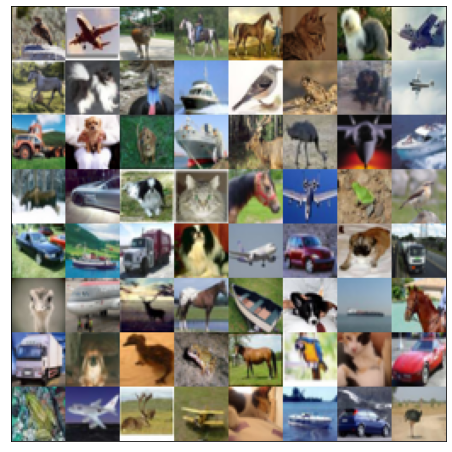

In [5]:
figsize(10,8)
big_img = stack_imgs(x[:,:-config.data.ydim].reshape([-1,C,32,32])*0.5+0.5)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


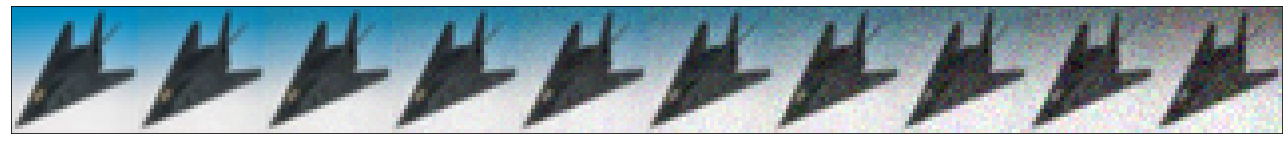

In [6]:
figsize(18,8)

n = 10
example = torch.load('example_image.tensor')
batch = example.repeat([n,1])
x_t = q_t(batch, torch.linspace(0,1,n))

img = np.zeros([1*32,n*32,3])
k = 0
for k in range(n):
    i, j = k//n, k % n
    img[i*32:(i+1)*32,j*32:(j+1)*32,:] = x_t[k].numpy().reshape([3,32,32]).transpose([1,2,0])*0.5+0.5
plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.tight_layout()
plt.savefig('example_' + config.model.task + '.png', format='png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


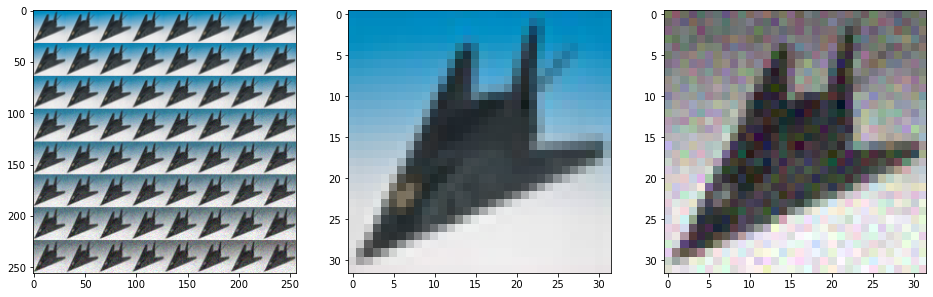

In [7]:
figsize(16,8)

batch = example.repeat([64,1])
x_t = q_t(batch, torch.linspace(0,1,64))

img = np.zeros([8*32,8*32,3])
k = 0
for k in range(64):
    i, j = k//8, k % 8
    img[i*32:(i+1)*32,j*32:(j+1)*32,:] = x_t[k].numpy().reshape([3,32,32]).transpose([1,2,0])*0.5+0.5
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(img[0:32,0:32,:])
plt.subplot(133)
plt.imshow(img[i*32:(i+1)*32,j*32:(j+1)*32,:])

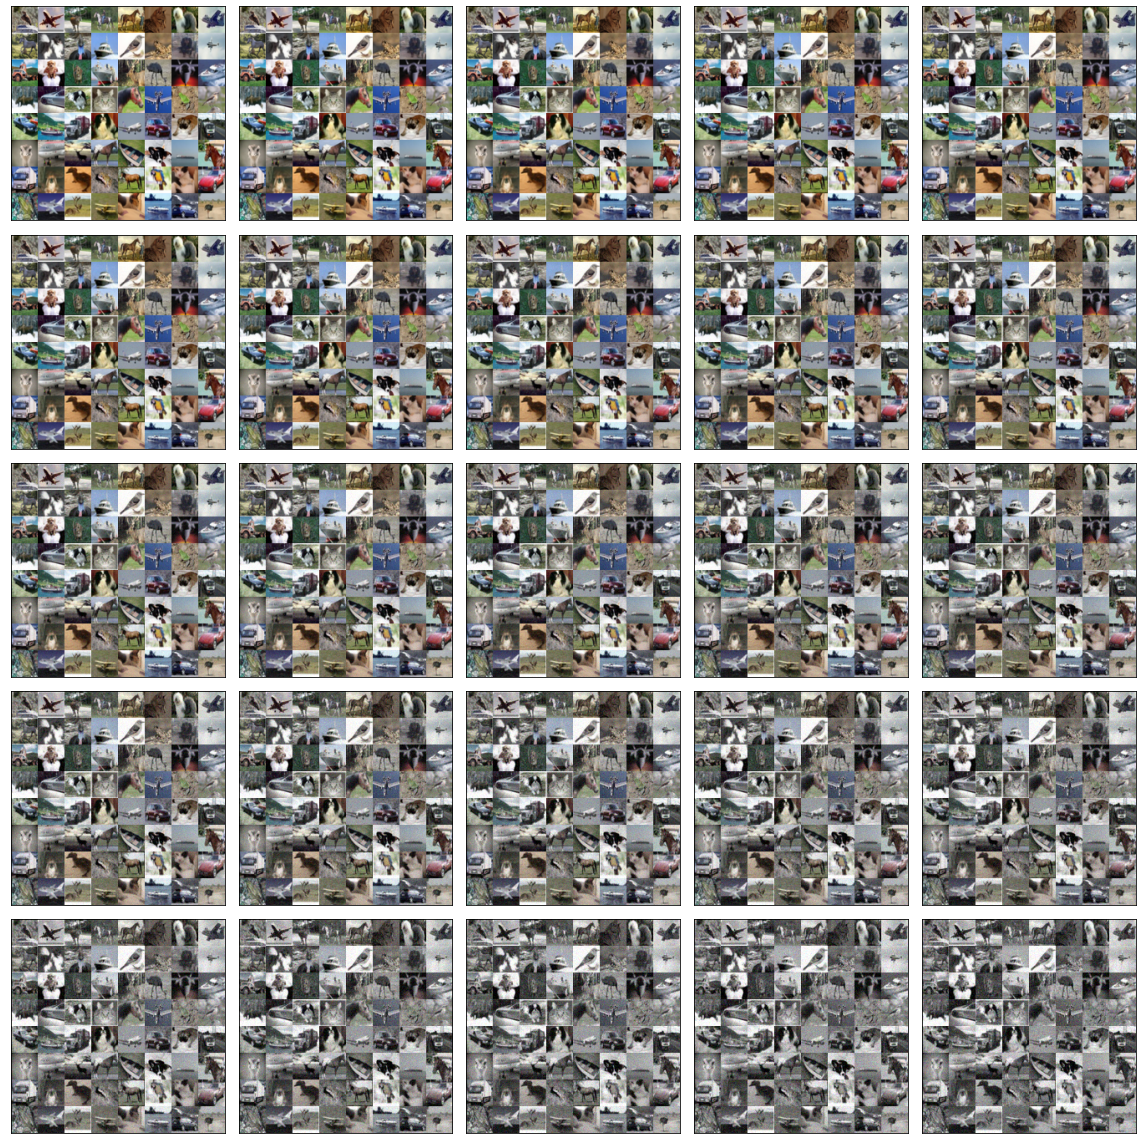

In [8]:
figsize(16,16)

batch = x[:1].repeat([64,1,1,1])
batch = batch.view(64, -1)
y = torch.zeros([64,config.data.ydim])
batch = torch.hstack([batch, y])
x_t = q_t(x, torch.linspace(0,1,64))

t = np.linspace(0,1,25)
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,5*i+j+1)
        img = q_t(x, torch.ones(64)*t[5*i+j])
        img = img.reshape([-1,C,32,32])*0.5+0.5
        plt.xticks([])
        plt.yticks([])
        plt.imshow(stack_imgs(img))
plt.tight_layout()